In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats

mpl.rcParams['pdf.fonttype'] = 42
%config InlineBackend.figure_format = 'retina'

In [ ]:
cmap = {
    'Control': '#000000',
    'Vehicle2': '#f08080',
    'Vehicle10': '#a9a9a9',
    'ABT-263': '#a9a9a9',
    'Venetoclax': '#a9a9a9',
    'Protac bcl2': '#f08080',
    'Protac bclxl': '#f08080'
    }

In [ ]:
# define a function to calculate the min and max of the SEM
def cal_sem(x:np.array):
    return np.mean(x) - stats.sem(x, nan_policy='omit'), np.mean(x) + stats.sem(x, nan_policy='omit')

# OFT

In [ ]:
oft = pd.read_excel('../data/bh_format.xlsx', sheet_name='oft')

In [ ]:
oft_long = oft.melt(id_vars=['id','Drug','Sex','aka'], value_vars=['Distance Total cm', 'Periphery Duration %', 'Center Duration %'])
# oft_long.aka = oft_long.aka.astype('category').cat.reorder_categories(['Vehicle','Drug1','Drug2','Drug3'])
oft_long.Drug = oft_long.Drug.astype('category').cat.reorder_categories(['Control','Vehicle10','Venetoclax','Vehicle2','Protac bcl2','Protac bclxl'])

In [ ]:
oft_dis = oft_long[oft_long.variable.str.startswith('Distance')].reset_index(drop=True)
oft_per = oft_long[~oft_long.variable.str.startswith('Distance')].reset_index(drop=True)
oft_per.variable = oft_per.variable.str.strip(' %')
oft_per.variable = oft_per.variable.astype('category').cat.reorder_categories(['Center Duration','Periphery Duration'])

In [ ]:
from statsmodels.stats.multitest import multipletests
drug = []
ttest=[]
for d in ['Venetoclax','Protac bcl2','Protac bclxl']:
    drug.append(d)
    if d.startswith('P'):
        ctr = 'Vehicle2'
    else:
        ctr = 'Vehicle10'
    st, p = stats.ttest_ind(oft_dis[(oft_dis.Drug == d)].value,
                            oft_dis[(oft_dis.Drug == ctr)].value)
    ttest.append(p)
ttest = multipletests(ttest, alpha=0.05, method='bonferroni')[1]
ttest

array([1.78652316e-01, 5.44371328e-07, 1.63439570e-04])

In [ ]:
drug

['Venetoclax', 'Protac bcl2', 'Protac bclxl']

In [ ]:
oft_dis = oft_dis[oft_dis.Drug != 'Protac bcl2'].copy()
oft_dis.Drug = oft_dis.Drug.cat.remove_unused_categories()

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_86390/3145574884.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['NT','Veh10','Ven','Veh2','P Bcl-xL'], rotation=90)


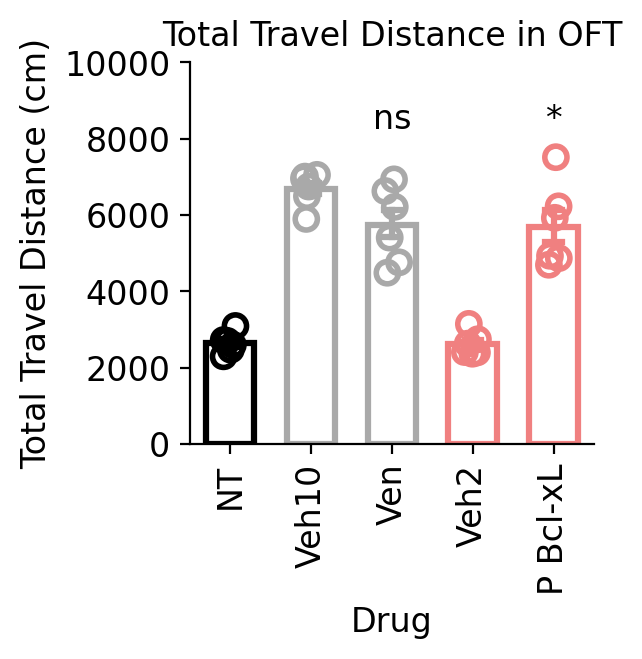

In [ ]:
fig, ax = plt.subplots(figsize=(2.75,2.5))
fig.tight_layout()
sns.barplot(data=oft_dis, x='Drug', y='value', hue='Drug',
            fill=False, errorbar=('ci', 68),
            capsize=0.2, ax=ax, width=0.6, palette=cmap)
sns.stripplot(data=oft_dis, x='Drug', y='value', hue='Drug', palette=cmap, zorder=1, marker="$\circ$", edgecolor="face", s=10)


ax.text(2, 8500, '*' if ttest[0] < 0.05 else 'ns', ha='center', va='center', fontsize=12)
ax.text(4, 8500, '*' if ttest[-1] < 0.05 else 'ns', ha='center', va='center', fontsize=12)


ax.set_ylabel('Total Travel Distance (cm)', fontsize=12)
ax.set_xlabel('Drug', fontsize=12)
ax.tick_params(labelsize=12)
ax.set_xticklabels(['NT','Veh10','Ven','Veh2','P Bcl-xL'], rotation=90)
ax.set_ylim(0, 10000)
ax.set_title('Total Travel Distance in OFT', fontsize=12)
for i in ['top', 'right']:
    ax.spines[i].set_visible(False)
fig.savefig('/Users/pax/Library/CloudStorage/OneDrive-KarolinskaInstitutet/BHDrug_plots/bh_oft_total_dis_new.pdf', bbox_inches='tight', dpi=300)

In [ ]:
from statsmodels.stats.multitest import multipletests
ttest={}
for loc in oft_per.variable.cat.categories:
    ttest[loc] = []
    for d in ['Venetoclax','Protac bcl2','Protac bclxl']:
        if d.startswith('P'):
            ctr = 'Vehicle2'
        else:
            ctr = 'Vehicle10'
        st, p = stats.ttest_ind(oft_per[(oft_per.variable == loc) & (oft_per.Drug == d)].value,
                                oft_per[(oft_per.variable == loc) & (oft_per.Drug == ctr)].value)
        ttest[loc].append(p)
    ttest[loc] = multipletests(ttest[loc], alpha=0.05, method='bonferroni')[1]
ttest

{'Center Duration': array([0.29172835, 1.        , 1.        ]),
 'Periphery Duration': array([0.29172889, 1.        , 1.        ])}

In [ ]:
oft_per = oft_per[oft_per.Drug != 'Protac bcl2'].copy()
oft_per.Drug = oft_per.Drug.cat.remove_unused_categories()

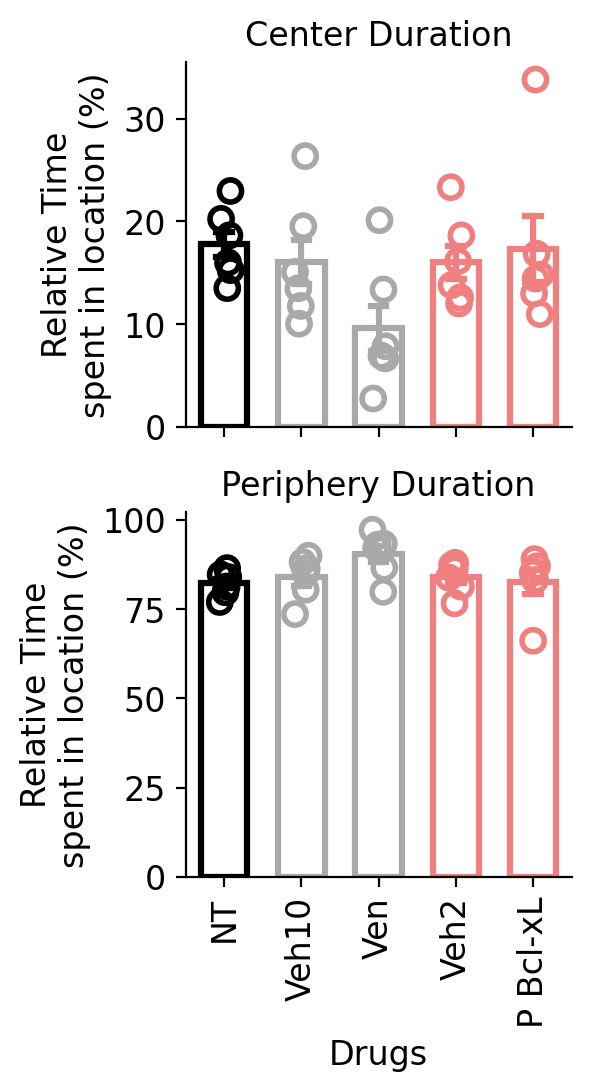

In [ ]:
g = sns.catplot(
    oft_per, kind="bar", fill=False, errorbar=('ci', 68), capsize=0.2,
    x="Drug" ,y="value", hue="Drug", row="variable", width=0.6,
    height=2.5, aspect=1.2, legend=False, sharey=False, palette=cmap)
g.map_dataframe(sns.stripplot, x="Drug", y="value", hue='Drug', zorder=1, dodge=False, palette=cmap, marker="$\circ$", edgecolor="face", s=10)
g.tight_layout()
g.tick_params(labelsize=12)
g.set_ylabels('Relative Time\nspent in location (%)', fontsize=12)
g.set_xlabels('Drugs', fontsize=12)
g.set_xticklabels(['NT','Veh10','Ven','Veh2','P Bcl-xL'], rotation=90)
g.set_titles('{row_name}', size=12)
# for i, ax in enumerate(g.axes.flat):
#     ax.set_ylim(0, 120 if i != 0 else 100)
#     ax.text(2, 110 if i != 0 else 45, '*' if ttest[oft_per.variable.cat.categories[i]][0] < 0.05 else 'ns', ha='center', va='center', fontsize=12)
#     ax.text(4, 110 if i != 0 else 45, '*' if ttest[oft_per.variable.cat.categories[i]][-1] < 0.05 else 'ns', ha='center', va='center', fontsize=12)
    # for j in range(len(drug)):
    #     ax.text(j+1, 110 if i != 0 else 45, '*' if ttest[oft_per.variable.cat.categories[i]][j] < 0.05 else 'ns', ha='center', va='center', fontsize=12)
g.axes[1][0].yaxis.get_major_ticks()[-1].label1.set_visible(False)
g.axes[1][0].yaxis.get_major_ticks()[-1].tick1line.set_visible(False)
g.savefig('/Users/pax/Library/CloudStorage/OneDrive-KarolinskaInstitutet/BHDrug_plots/bh_oft_percent_loc_new.pdf', bbox_inches='tight', dpi=300)

# EPM

In [ ]:
epm = pd.read_excel('../data/bh_format.xlsx', sheet_name='epm')

In [ ]:
epm_long = epm.melt(id_vars=['id','Drug','Sex','aka'], value_vars=['Distance Total cm', 'Center Duration %','Open Arm Duration %','Closed Arm Duration %'])
epm_long.Drug = epm_long.Drug.astype('category').cat.reorder_categories(['Control','Vehicle10','Venetoclax','Vehicle2','Protac bcl2','Protac bclxl'])

In [ ]:
epm_dis = epm_long[epm_long.variable.str.startswith('Distance')].reset_index(drop=True)
epm_per = epm_long[~epm_long.variable.str.startswith('Distance')].reset_index(drop=True)
epm_per.variable = epm_per.variable.str.strip(' %')
epm_per.variable = epm_per.variable.astype('category').cat.reorder_categories(['Center Duration','Open Arm Duration','Closed Arm Duration'])

In [ ]:
from statsmodels.stats.multitest import multipletests
drug = []
ttest=[]
for d in ['Venetoclax','Protac bcl2','Protac bclxl']:
    drug.append(d)
    if d.startswith('P'):
        ctr = 'Vehicle2'
    else:
        ctr = 'Vehicle10'
    st, p = stats.ttest_ind(epm_dis[(epm_dis.Drug == d)].value,
                            epm_dis[(epm_dis.Drug == ctr)].value)
    ttest.append(p)
ttest = multipletests(ttest, alpha=0.05, method='bonferroni')[1]
ttest

array([1., 1., 1.])

In [ ]:
epm_dis = epm_dis[epm_dis.Drug != 'Protac bcl2'].copy()
epm_dis.Drug = epm_dis.Drug.cat.remove_unused_categories()

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_86390/2705178569.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['NT','Veh10','Ven','Veh2','P Bcl-xL'], rotation=90)


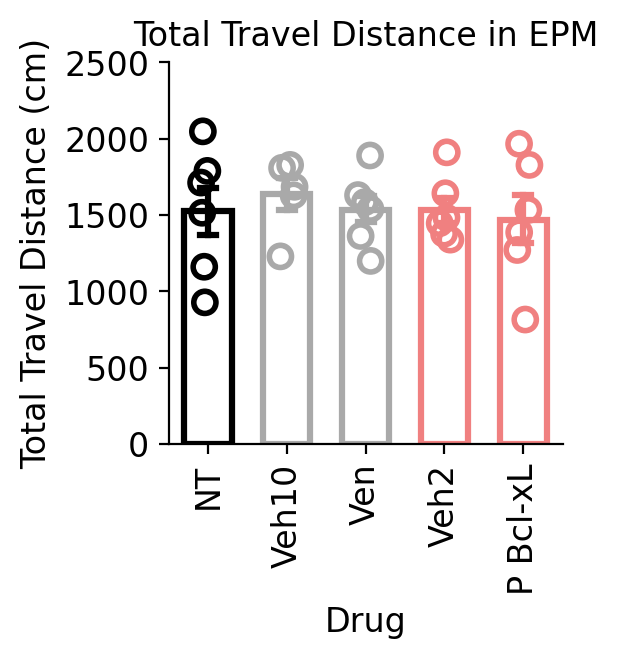

In [ ]:
fig, ax = plt.subplots(figsize=(2.7,2.5))
fig.tight_layout()
sns.barplot(data=epm_dis, x='Drug', y='value', hue='Drug',
            fill=False, errorbar=('ci', 68), capsize=0.2,
            ax=ax, width=0.6, palette=cmap)
sns.stripplot(data=epm_dis, x='Drug', y='value', hue='Drug', palette=cmap,
              zorder=0, marker="$\circ$", edgecolor="face", s=10, dodge=False)
# for i in range(len(drug)):
#     ax.text(i+1, 2300, '*' if ttest[i] < 0.05 else 'ns', ha='center', va='center', fontsize=12)
ax.set_ylabel('Total Travel Distance (cm)', fontsize=12)
ax.set_xlabel('Drug', fontsize=12)
ax.tick_params(labelsize=12)
ax.set_xticklabels(['NT','Veh10','Ven','Veh2','P Bcl-xL'], rotation=90)
ax.set_ylim(0, 2500)
ax.set_title('Total Travel Distance in EPM', fontsize=12)
for i in ['top', 'right']:
    ax.spines[i].set_visible(False)
fig.savefig('/Users/pax/Library/CloudStorage/OneDrive-KarolinskaInstitutet/BHDrug_plots/bh_epm_total_dis_new.pdf', bbox_inches='tight', dpi=300)

In [ ]:
from statsmodels.stats.multitest import multipletests
ttest={}
for loc in epm_per.variable.cat.categories:
    ttest[loc] = []
    for d in ['Venetoclax','Protac bcl2','Protac bclxl']:
        drug.append(d)
        if d.startswith('P'):
            ctr = 'Vehicle2'
        else:
            ctr = 'Vehicle10'
        st, p = stats.ttest_ind(epm_per[(epm_per.variable == loc) & (epm_per.Drug == d)].value,
                                epm_per[(epm_per.variable == loc) & (epm_per.Drug == ctr)].value)
        ttest[loc].append(p)
    ttest[loc] = multipletests(ttest[loc], alpha=0.05, method='bonferroni')[1]
ttest

{'Center Duration': array([1.        , 1.        , 0.75344138]),
 'Open Arm Duration': array([1., 1., 1.]),
 'Closed Arm Duration': array([1.       , 1.       , 0.7868293])}

In [ ]:
epm_per = epm_per[epm_per.Drug != 'Protac bcl2'].copy()
epm_per.Drug = epm_per.Drug.cat.remove_unused_categories()

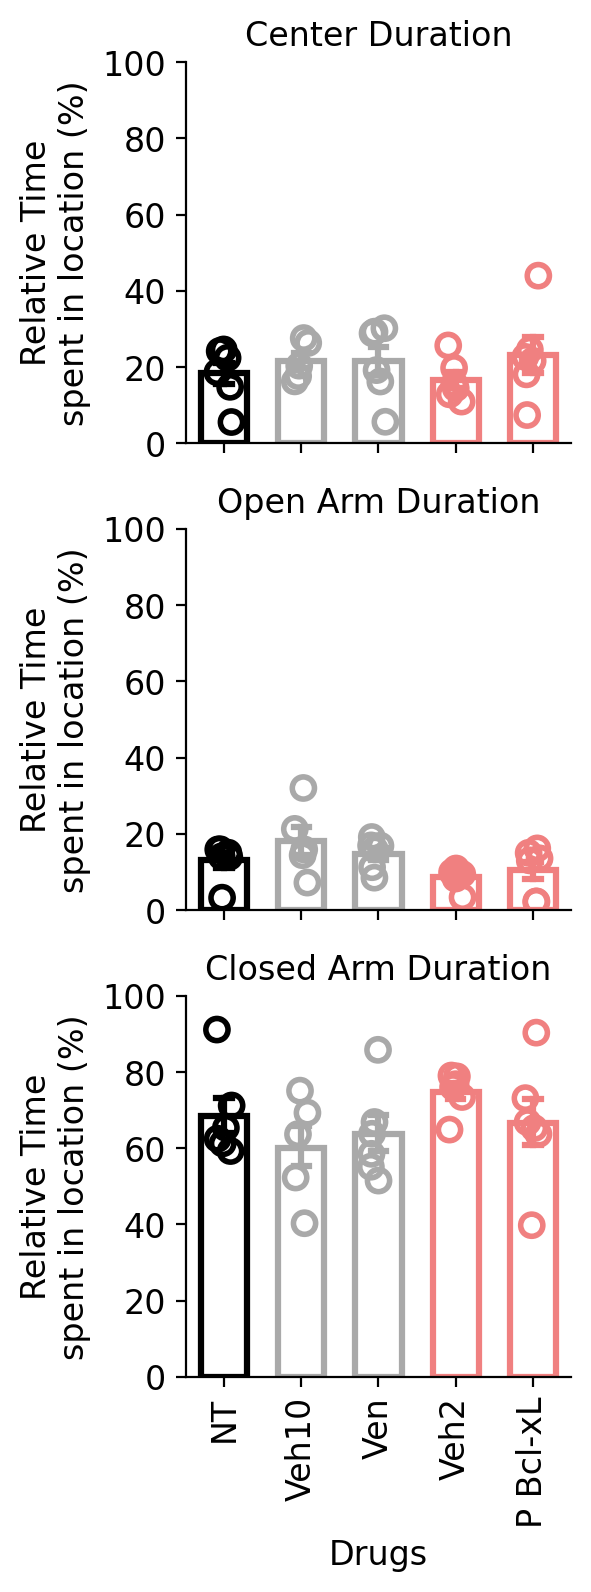

In [ ]:
g = sns.catplot(
    epm_per, kind="bar", fill=False, errorbar=('ci', 68), capsize=0.2,
    x="Drug" ,y="value", hue="Drug", row="variable", palette=cmap, width=0.6,
    height=2.5, aspect=1.2, legend=False, facet_kws=dict(ylim=(0,100)))
g.map_dataframe(sns.stripplot, x="Drug", y="value", hue='Drug', palette=cmap,
                zorder=1, dodge=False, marker="$\circ$", edgecolor="face", s=10)
g.tight_layout()
g.tick_params(labelsize=12)
g.set_xticklabels(['NT','Veh10','Ven','Veh2','P Bcl-xL'], rotation=90)
g.set_ylabels('Relative Time\nspent in location (%)', fontsize=12)
g.set_xlabels('Drugs', fontsize=12)
g.set_titles('{row_name}', size=12)
# for i, ax in enumerate(g.axes.flat):
#     for j in range(len(drug)):
#         ax.text(j+1, 60 if i != 2 else 99, '*' if ttest[epm_per.variable.cat.categories[i]][j] < 0.05 else 'ns', ha='center', va='center', fontsize=12)
g.savefig('/Users/pax/Library/CloudStorage/OneDrive-KarolinskaInstitutet/BHDrug_plots/bh_epm_percent_loc_new.pdf', bbox_inches='tight', dpi=300)

# Rod

In [ ]:
rod = pd.read_excel('../data/bh_format.xlsx', sheet_name='rod')

In [ ]:
rod_time = rod.melt(id_vars=['id','Drug','Sex','aka'], value_vars=rod.columns[rod.columns.str.contains('(s)')][2:]) # only used the last 3 trials
rod_rpm = rod.melt(id_vars=['id','Drug','Sex','aka'], value_vars=rod.columns[rod.columns.str.contains('(rpm)')][2:])

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_86390/3805887013.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  rod_time = rod.melt(id_vars=['id','Drug','Sex','aka'], value_vars=rod.columns[rod.columns.str.contains('(s)')][2:]) # only used the last 3 trials
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_86390/3805887013.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  rod_rpm = rod.melt(id_vars=['id','Drug','Sex','aka'], value_vars=rod.columns[rod.columns.str.contains('(rpm)')][2:])


In [ ]:
rod_time['Measure'] = 'Time'
rod_rpm['Measure'] = 'RPM'
rod_long = pd.concat([rod_time, rod_rpm], axis=0, ignore_index=True).reset_index(drop=True)

In [ ]:
# rod_long.Drug = rod_long.Drug.astype('category').cat.reorder_categories(['Control','Vehicle2','Vehicle10','Venetoclax','Protac bcl2','Protac bclxl'])
rod_long.Drug = rod_long.Drug.astype('category').cat.reorder_categories(['Control','Vehicle10','Venetoclax','Vehicle2','Protac bcl2','Protac bclxl'])
rod_long.Measure = rod_long.Measure.astype('category').cat.reorder_categories(['Time','RPM'])

In [ ]:
rod_long_mean = rod_long.groupby(['id','Drug','Measure']).value.mean().dropna().unstack().reset_index(level=1).reset_index().melt(id_vars=['id','Drug'],
                                                                                                                                  value_vars=['Time','RPM'], var_name='Measure')

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_86390/410719100.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rod_long_mean = rod_long.groupby(['id','Drug','Measure']).value.mean().dropna().unstack().reset_index(level=1).reset_index().melt(id_vars=['id','Drug'],


In [ ]:
rod_long_mean.Measure = rod_long_mean.Measure.astype('category').cat.reorder_categories(['Time','RPM'])
rod_long_mean.Drug = rod_long_mean.Drug.astype('category').cat.reorder_categories(['Control','Vehicle10','Venetoclax','Vehicle2','Protac bcl2','Protac bclxl'])

In [ ]:
from statsmodels.stats.multitest import multipletests
ttest={}
for m in rod_long_mean.Measure.cat.categories:
    ttest[m] = []
    for d in ['Venetoclax','Protac bcl2','Protac bclxl']:
        if d.startswith('P'):
            c = 'Vehicle2'
        else:
            c = 'Vehicle10'
        st, p = stats.ttest_ind(rod_long_mean[(rod_long_mean.Measure == m) & (rod_long_mean.Drug == d)].value,
                                rod_long_mean[(rod_long_mean.Measure == m) & (rod_long_mean.Drug == c)].value)
        ttest[m].append(p)
    ttest[m] = multipletests(ttest[m], alpha=0.05, method='bonferroni')[1]
ttest

{'Time': array([0.62972582, 0.08407722, 1.        ]),
 'RPM': array([0.7489657 , 0.14029174, 1.        ])}

In [ ]:
ttest.keys()

dict_keys(['Time', 'RPM'])

In [ ]:
rod_long_mean = rod_long_mean[rod_long_mean.Drug != 'Protac bcl2']
rod_long_mean.Drug = rod_long_mean.Drug.cat.remove_unused_categories()

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_86390/3690838851.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rod_long_mean.Drug = rod_long_mean.Drug.cat.remove_unused_categories()


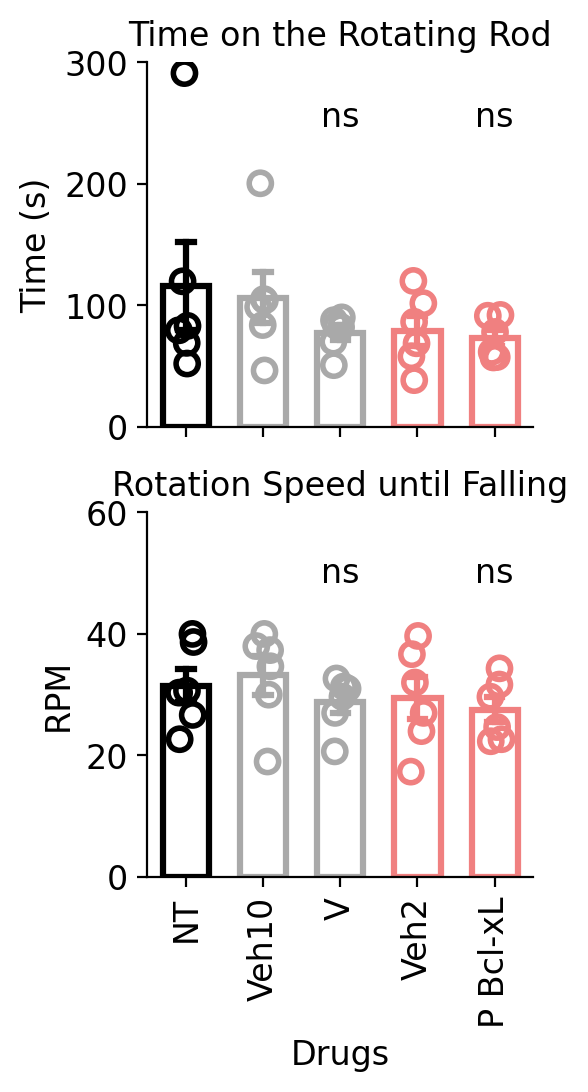

In [ ]:
g = sns.catplot(
    rod_long_mean, kind="bar", fill=False, errorbar=cal_sem, capsize=0.2,
    x="Drug" ,y="value", hue="Drug", row="Measure", palette=cmap, width=0.6,
    height=2.5, aspect=1.2, legend=False, sharey=False)
g.map_dataframe(sns.stripplot, x="Drug", y="value", hue='Drug', palette=cmap,
                zorder=1, dodge=False, marker="$\circ$", edgecolor="face", s=10)
g.tight_layout()
g.tick_params(labelsize=12)
g.set_xticklabels(['NT','Veh10','V','Veh2','P Bcl-xL'], rotation=90)
g.set_xlabels('Drugs', fontsize=12)
g.set_titles('{row_name}', size=12)
for i, ax in enumerate(g.axes.flat):
    if i == 0:
        ax.set_ylim(0, 300)
        ax.set_ylabel('Time (s)', fontsize=12)
        ax.set_title('Time on the Rotating Rod', fontsize=12)
        k = 'Time'
    else:
        ax.set_ylim(0, 60)
        ax.set_ylabel('RPM', fontsize=12)
        ax.set_title('Rotation Speed until Falling', fontsize=12)
        k = 'RPM'
        
    ax.text(2, 255 if i == 0 else 50, '*' if ttest[k][0] < 0.05 else 'ns', ha='center', va='center', fontsize=12)
    # ax.text(3, 255 if i == 0 else 50, '*' if ttest[k][1] < 0.05 else 'ns', ha='center', va='center', fontsize=12)
    ax.text(4, 255 if i == 0 else 50, '*' if ttest[k][2] < 0.05 else 'ns', ha='center', va='center', fontsize=12)
    # for idx,j in enumerate(range(2,2+3)):
        # ax.text(j, 255 if i == 0 else 50, '*' if ttest[list(ttest.keys())[i]][j] < 0.05 else 'ns', ha='center', va='center', fontsize=12)
g.savefig('/Users/pax/Library/CloudStorage/OneDrive-KarolinskaInstitutet/BHDrug_plots/bh_rod_new.pdf', bbox_inches='tight', dpi=300)

# Beam

In [ ]:
beam = pd.read_excel('../data/bh_format.xlsx', sheet_name='beam')

In [ ]:
beam_time = beam.melt(id_vars=['id','Drug','Sex','aka','Beam'], value_vars=beam.columns[beam.columns.str.contains('(s)')])
beam_score = beam.melt(id_vars=['id','Drug','Sex','aka','Beam'], value_vars=beam.columns[beam.columns.str.contains('Score')])

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_50275/4103444618.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  beam_time = beam.melt(id_vars=['id','Drug','Sex','aka','Beam'], value_vars=beam.columns[beam.columns.str.contains('(s)')])


In [ ]:
beam_time['Measure'] = 'Time'
beam_score['Measure'] = 'Score'
beam_long = pd.concat([beam_time, beam_score], axis=0, ignore_index=True).reset_index(drop=True)

In [ ]:
# beam_long.Drug = beam_long.Drug.astype('category').cat.reorder_categories(['Control','Vehicle2','Vehicle10','Venetoclax','Protac bcl2','Protac bclxl'])
beam_long.Drug = beam_long.Drug.astype('category').cat.reorder_categories(['Control','Vehicle10','Venetoclax','Vehicle2','Protac bcl2','Protac bclxl'])
beam_long.Measure = beam_long.Measure.astype('category').cat.reorder_categories(['Time','Score'])
beam_long.Beam = beam_long.Beam.astype('category').cat.reorder_categories(['Small','Medium','Large','Largest'])
beam_long.Beam = beam_long.Beam.astype('category').cat.rename_categories({'Largest':'X-Large'})

In [ ]:
beam_long_mean = beam_long.groupby(['id','Drug','Measure','Beam']).value.mean().dropna().unstack()\
    .reset_index(level=[1,2]).reset_index()\
        .melt(id_vars=['id','Drug','Measure'], value_vars=beam_long.Beam.cat.categories)

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_50275/1887249491.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  beam_long_mean = beam_long.groupby(['id','Drug','Measure','Beam']).value.mean().dropna().unstack()\


In [ ]:
beam_long_mean.Measure = beam_long_mean.Measure.astype('category').cat.reorder_categories(['Time','Score'])
beam_long_mean.Drug = beam_long_mean.Drug.astype('category').cat.reorder_categories(['Control','Vehicle10','Venetoclax','Vehicle2','Protac bcl2','Protac bclxl'])
beam_long_mean.Beam = beam_long_mean.Beam.astype('category').cat.reorder_categories(['Small','Medium','Large','X-Large'])

In [ ]:
from statsmodels.stats.multitest import multipletests
ttest={}
for m in beam_long_mean.Measure.cat.categories:
    ttest[m] = {}
    for b in beam_long_mean.Beam.cat.categories:
        ttest[m][b] = []
        for d in ['Venetoclax','Protac bcl2','Protac bclxl']:
            if d.startswith('P'):
                c = 'Vehicle2'
            else:
                c = 'Vehicle10'
            st, p = stats.ttest_ind(beam_long_mean[(beam_long_mean.Measure == m) & (beam_long_mean.Beam == b) & (beam_long_mean.Drug == d)].value,
                                    beam_long_mean[(beam_long_mean.Measure == m) & (beam_long_mean.Beam == b) & (beam_long_mean.Drug == c)].value)
            ttest[m][b].append(p)
        ttest[m][b] = multipletests(ttest[m][b], alpha=0.05, method='bonferroni')[1]
ttest

{'Time': {'Small': array([1., 1., 1.]),
  'Medium': array([ 1., nan, nan]),
  'Large': array([1., 1., 1.]),
  'X-Large': array([ 1., nan, nan])},
 'Score': {'Small': array([1., 1., 1.]),
  'Medium': array([ 1., nan, nan]),
  'Large': array([1., 1., 1.]),
  'X-Large': array([ 1., nan, nan])}}

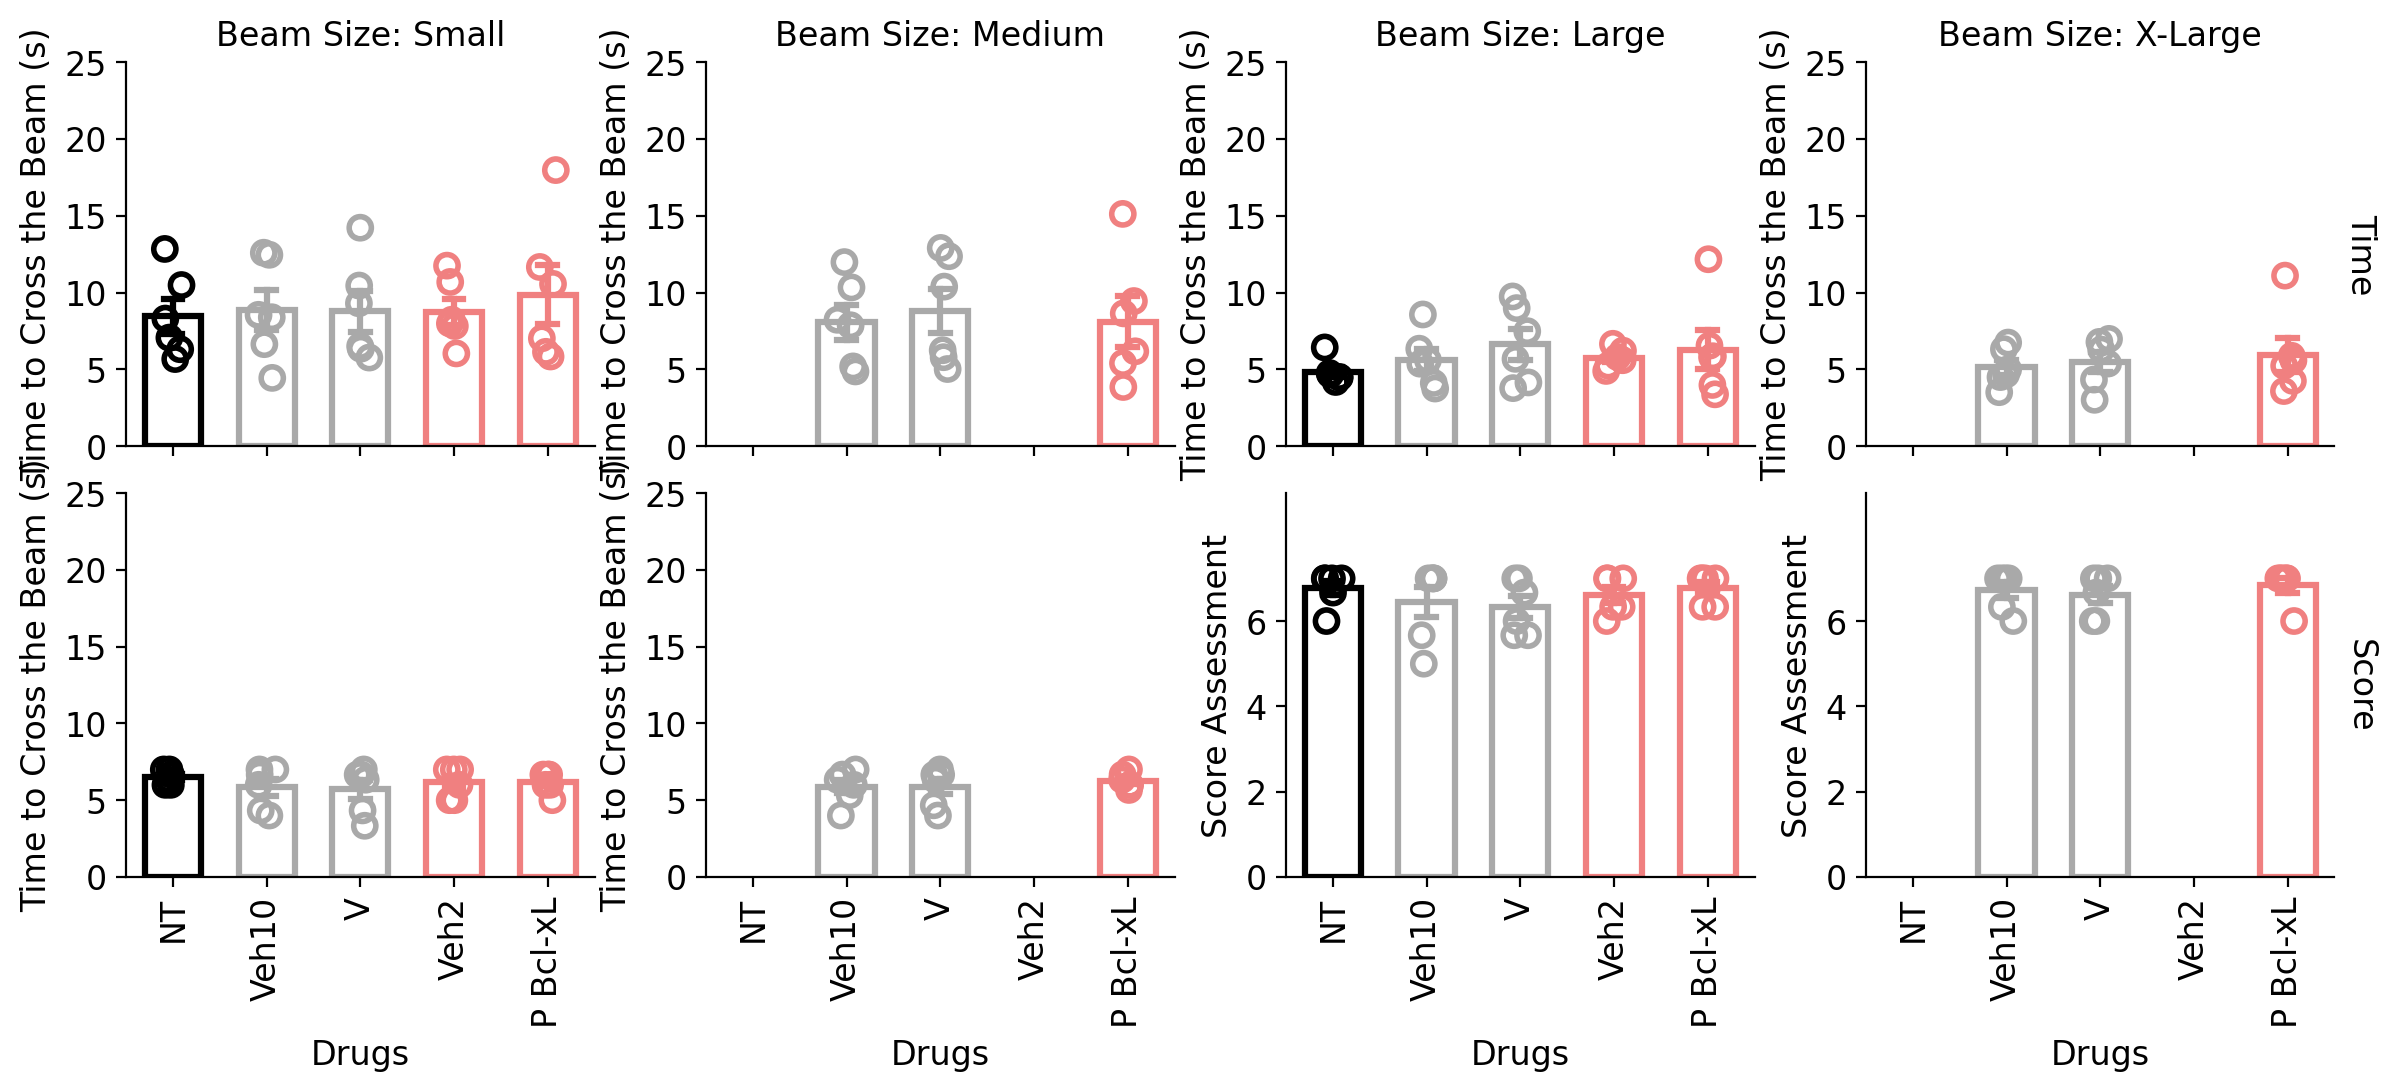

In [ ]:
g = sns.catplot(
    beam_long_mean, kind="bar", fill=False, errorbar=cal_sem, capsize=0.2,
    x="Drug" ,y="value", hue='Drug', row="Measure", col="Beam", palette=cmap, width=0.6,
    height=2.5, aspect=1.2, margin_titles=True, sharey=False)
g.map_dataframe(sns.stripplot, x="Drug", y="value", hue='Drug', palette=cmap,
                zorder=1, size=10, dodge=False, marker="$\circ$", edgecolor="face")
# g.tight_layout()
# g.legend.set_visible(False)
g.tick_params(labelsize=12)
g.set_xticklabels(['NT','Veh10','V','Veh2','P Bcl-xL'], rotation=90)
g.set_xlabels('Drugs', fontsize=12)
g.set_titles(row_template='{row_name}', col_template='Beam Size: {col_name}', size=12)
for i, ax in enumerate(g.axes.flat):
    if i in list(range(6)):
        ax.set_ylim(0, 25)
        ax.set_ylabel('Time to Cross the Beam (s)', fontsize=12)
    else:
        ax.set_ylim(0, 9)
        ax.set_ylabel('Score Assessment', fontsize=12)
        for t in [-1,-2]:
            ax.yaxis.get_major_ticks()[t].label1.set_visible(False)
            ax.yaxis.get_major_ticks()[t].tick1line.set_visible(False)
    # for m in beam_long_mean.Measure.cat.categories:
    #     for b in beam_long_mean.Beam.cat.categories:
    #         for j in range(len(drug)):
    #             ax.text(j+1, 23 if i in list(range(4)) else 8,
    #                     '*' if ttest[m][b][j] < 0.05 else 'ns',
    #                     ha='center', va='center', fontsize=12)
g.savefig('/Users/pax/Library/CloudStorage/OneDrive-KarolinskaInstitutet/BHDrug_plots/bh_beam_new.pdf', bbox_inches='tight', dpi=300)